# Problem 4.3 – Variational Autoencoder (VAE)

## 4.3.1 Conceptual introduction to Variational Autoencoders (VAEs)

A Variational Autoencoder (VAE) is a generative model that learns a probabilistic latent representation of data.
It consists of:
- an encoder $q_\phi(\mathbf{z}\mid\mathbf{x})$ that maps data $\mathbf{x}$ to a distribution over latent variables $\mathbf{z}$,
- a decoder $p_\theta(\mathbf{x}\mid\mathbf{z})$ that maps latent variables back to a distribution over data.

### Notation and assumptions
- Prior on latent variables: $p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$.
- Variational posterior (encoder): $q_\phi(\mathbf{z}\mid\mathbf{x}) = \mathcal{N}\!\big(\boldsymbol\mu_\phi(\mathbf{x}), \mathrm{diag}(\boldsymbol\sigma^2_\phi(\mathbf{x}))\big)$.
  In practice we predict $\boldsymbol\mu$ and $\log\boldsymbol\sigma^2$ (aka `logvar`) for numerical stability.
- Likelihood (decoder): $p_\theta(\mathbf{x}\mid\mathbf{z})$.
  - If we use mean squared error (MSE) as reconstruction loss, this corresponds to a Gaussian likelihood with fixed variance: $p_\theta(\mathbf{x}\mid\mathbf{z}) = \mathcal{N}(\hat{\mathbf{x}}_\theta(\mathbf{z}), \beta \mathbf{I})$ (for some $\beta>0$).
  - If we use binary cross-entropy (BCE) on $[0,1]$ images, this corresponds to a Bernoulli likelihood with mean $\hat{\mathbf{x}}_\theta(\mathbf{z})$.

### Objective: ELBO
Maximizing the log marginal likelihood $\log p_\theta(\mathbf{x})$ directly is intractable,
so we maximize the Evidence Lower BOund (ELBO):
$$
\mathcal{L}_{\text{ELBO}}(\theta,\phi;\mathbf{x})
= \mathbb{E}_{q_\phi(\mathbf{z}\mid\mathbf{x})}\big[\log p_\theta(\mathbf{x}\mid\mathbf{z})\big]
- \mathrm{KL}\!\big(q_\phi(\mathbf{z}\mid\mathbf{x}) \,\|\, p(\mathbf{z})\big).
$$
Training conventionally minimizes the negative ELBO:
$$
\mathcal{L}_{\text{VAE}}(\mathbf{x})
= -\,\mathbb{E}_{q_\phi(\mathbf{z}\mid\mathbf{x})}\big[\log p_\theta(\mathbf{x}\mid\mathbf{z})\big]
+ \mathrm{KL}\!\big(q_\phi(\mathbf{z}\mid\mathbf{x}) \,\|\, p(\mathbf{z})\big).
$$

For Gaussian decoder with fixed variance $\beta\mathbf{I}$, the first term reduces (up to a constant scale) to the per-pixel MSE between $\mathbf{x}$ and $\hat{\mathbf{x}}=\hat{\mathbf{x}}_\theta(\mathbf{z})$:
$$
-\,\mathbb{E}_{q}\big[\log p_\theta(\mathbf{x}\mid\mathbf{z})\big]
\propto \frac{1}{2\beta}\,\|\mathbf{x}-\hat{\mathbf{x}}\|_2^2.
$$
In practice we implement it as an MSE over pixels/channels, reduced to a scalar per batch.

### Closed-form KL for diagonal Gaussians
With $q_\phi(\mathbf{z}\mid\mathbf{x})=\mathcal{N}(\boldsymbol\mu, \mathrm{diag}(\boldsymbol\sigma^2))$ and $p(\mathbf{z})=\mathcal{N}(\mathbf{0},\mathbf{I})$:
$$
\mathrm{KL}\!\big(q \,\|\, p\big)
= \frac{1}{2}\sum_{i=1}^d \big(\mu_i^2 + \sigma_i^2 - \log \sigma_i^2 - 1\big).
$$
Using `logvar = \log \sigma^2`, one computes $\sigma^2 = \exp(\text{logvar})$ and uses the same formula.

### Reparameterization trick
To backpropagate through sampling from $q_\phi(\mathbf{z}\mid\mathbf{x})$, we write
$$
\mathbf{z} = \boldsymbol\mu + \boldsymbol\sigma \odot \boldsymbol\epsilon,
\quad \boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0},\mathbf{I}),
\quad \boldsymbol\sigma = \exp\!\big(\tfrac{1}{2}\,\text{logvar}\big).
$$
This makes sampling a deterministic function of $(\boldsymbol\mu,\text{logvar},\boldsymbol\epsilon)$, enabling gradient flow.

### Practical implementation notes (for the next steps)
- Encoder outputs: `mu`, `logvar`; use a `Sampling` layer to produce `z`.
- Decoder outputs: reconstruction $\hat{\mathbf{x}}$ in $[0,1]$ via a final `sigmoid` when inputs are normalized to $[0,1]$.
- Loss per batch:
  - Reconstruction: sum over pixels/channels per sample, then mean over batch (consistent scalar).
  - KL: sum over latent dims per sample, then mean over batch.
  - Total: `loss = recon_loss + kl_loss` (matching the exercise statement).
- Architectures for 28×28 images:
  - Encoder: Conv2D blocks with strides 2 to reduce to 7×7, then Dense to latent parameters.
  - Decoder: Dense to 7×7×C, then Conv2DTranspose with strides 2 to upsample back to 28×28.
- 2D latent ($d=2$) enables direct scatter plots and grid sampling visualizations.
- Uncertainty maps: multiple stochastic decodes for the same input yield per-pixel variance heatmaps.

### What to remember
- VAE optimizes a trade-off: accurate reconstructions vs. latent regularity (KL toward a standard normal).
- Using MSE corresponds to a Gaussian decoder; BCE corresponds to a Bernoulli decoder.
- Reparameterization trick is the key to make stochastic sampling differentiable.
- For diagonal Gaussians, the KL term is analytic and cheap to compute.


---

## 4.3.2 Fashion-MNIST: load, normalize, and visualize one sample per class

What we will do:
- Download Fashion-MNIST (60k train, 10k test), grayscale 28×28 images.
- Normalize to [0,1] and add a channel dimension -> shape (N, 28, 28, 1).
- Plot one randomly selected sample for each of the 10 classes.
- Optionally restrict training to the first 10,000 samples for speed (as allowed by the exercise).

Why:
- Normalization stabilizes optimization for subsequent model training.
- The channel dimension is required by Conv2D layers.
- Per-class samples help us visually inspect the dataset.

In [1]:
pip install tensorflow-macos tensorflow-metal


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports and basic setup for this section
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns





In [3]:
# Reproducibility (subject to GPU/cuDNN determinism limits)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Plot style
sns.set(context="notebook", style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (5.5, 5.0)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11

In [4]:
# Load Fashion-MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize to [0,1] and add channel dimension
x_train = (x_train.astype("float32") / 255.0)[..., None]  # (N, 28, 28, 1)
x_test  = (x_test.astype("float32")  / 255.0)[..., None]

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print("Train:", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)

# Optionally limit to first 10k training samples for speed
USE_FIRST_10K = False  # set to False for the full 60k
if USE_FIRST_10K:
    x_train = x_train[:10000]
    y_train = y_train[:10000]
    print("Using subset of training data:", x_train.shape, y_train.shape)

Train: (60000, 28, 28, 1) (60000,)
Test:  (10000, 28, 28, 1) (10000,)


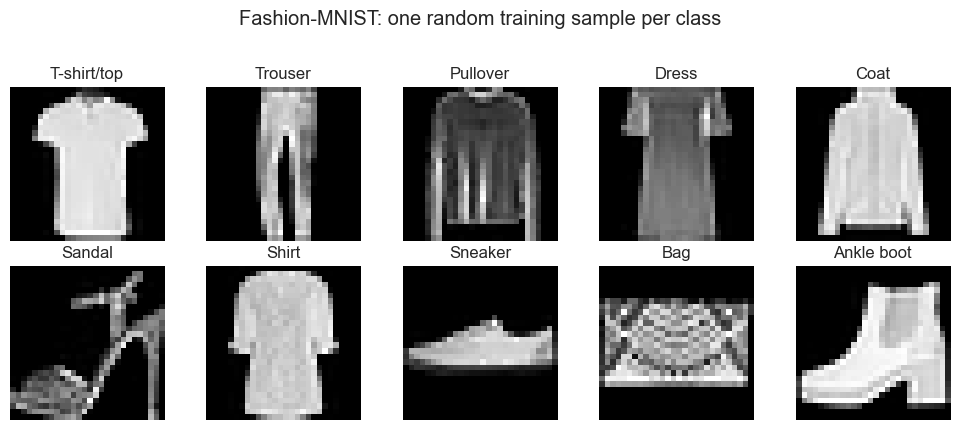

In [5]:
# Plot one random sample per class from the (possibly reduced) training set
rng = np.random.default_rng(SEED)
fig, axes = plt.subplots(2, 5, figsize=(10, 4.2))
picked_indices = []

for c in range(10):
    indices = np.where(y_train == c)[0]
    idx = rng.choice(indices)
    picked_indices.append(idx)

for ax, idx, c in zip(axes.ravel(), picked_indices, range(10)):
    ax.imshow(x_train[idx].squeeze(), cmap="gray", vmin=0, vmax=1)
    ax.set_title(class_names[c])
    ax.axis("off")

fig.suptitle("Fashion-MNIST: one random training sample per class", y=1.02)
plt.tight_layout()
plt.show()

---

## 4.3.3 Implement VAE loss: MSE reconstruction + KL divergence

We implement three small, composable functions:

- `reconstruction_loss_mse(x, x_hat)`: per-pixel squared error, summed over spatial/channel dims per sample, then averaged over the batch to return a scalar.
- `kl_loss_diag_gaussian(mu, log_var)`: closed-form KL for a diagonal Gaussian posterior against a standard normal prior, summed over latent dims per sample, then averaged over the batch to return a scalar.
- `vae_total_loss(x, x_hat, mu, log_var)`: total VAE loss as the sum of reconstruction and KL losses (scalar).

In [6]:

def reconstruction_loss_mse(x: tf.Tensor, x_hat: tf.Tensor) -> tf.Tensor:
    """
    Mean squared reconstruction error.
    Reduction: sum over (H, W, C) per sample, then mean over batch -> scalar.
    """
    per_pixel = tf.math.squared_difference(x, x_hat)
    per_sample = tf.reduce_sum(per_pixel, axis=[1, 2, 3])
    return tf.reduce_mean(per_sample)

def kl_loss_diag_gaussian(mu: tf.Tensor, log_var: tf.Tensor) -> tf.Tensor:
    """
    Closed-form KL(q || p) with q = N(mu, diag(exp(log_var))) and p = N(0, I).
    Reduction: sum over latent dims per sample, then mean over batch -> scalar.
    """
    # sigma^2 = exp(log_var)
    kl_per_sample = 0.5 * tf.reduce_sum(
        tf.square(mu) + tf.exp(log_var) - log_var - 1.0, axis=1
    )
    return tf.reduce_mean(kl_per_sample)

def vae_total_loss(x: tf.Tensor, x_hat: tf.Tensor, mu: tf.Tensor, log_var: tf.Tensor) -> tf.Tensor:
    """
    Total VAE loss: reconstruction (MSE) + KL. Returns a scalar.
    """
    recon = reconstruction_loss_mse(x, x_hat)
    kl = kl_loss_diag_gaussian(mu, log_var)
    return recon + kl

---
## 4.3.4 VAE with latent size D_h = 2, training, and reconstructions

What we will do:
- Build an encoder (Conv2D) that outputs `mu` and `log_var` for a 2D latent space, plus a `Sampling` layer (reparameterization).
- Build a decoder (Conv2DTranspose) that maps latent vectors back to 28×28×1 with a final sigmoid.
- Define a minimal `VAE` model with a custom `train_step` that uses the losses from 4.3.3.
- Train the model on Fashion-MNIST and display input vs reconstruction for 10 random test samples.

In [7]:
from tensorflow.keras import layers

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps

def build_encoder(latent_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(inputs)  # 14x14
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)       # 7x7
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    mu = layers.Dense(latent_dim, name="z_mu")(x)          # linear activation
    log_var = layers.Dense(latent_dim, name="z_log_var")(x)  # linear activation
    z = Sampling()([mu, log_var])
    return keras.Model(inputs, [mu, log_var, z], name=f"encoder_ld{latent_dim}")

def build_decoder(latent_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)  # 14x14
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)  # 28x28
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
    outputs = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name=f"decoder_ld{latent_dim}")

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder: keras.Model, decoder: keras.Model, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        with tf.GradientTape() as tape:
            mu, log_var, z = self.encoder(x, training=True)
            x_hat = self.decoder(z, training=True)
            recon = reconstruction_loss_mse(x, x_hat)
            kl = kl_loss_diag_gaussian(mu, log_var)
            loss = recon + kl
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        mu, log_var, z = self.encoder(x, training=False)
        x_hat = self.decoder(z, training=False)
        recon = reconstruction_loss_mse(x, x_hat)
        kl = kl_loss_diag_gaussian(mu, log_var)
        loss = recon + kl
        return {"loss": loss, "recon_loss": recon, "kl_loss": kl}

In [10]:
# Instantiate, compile, and train VAE with latent size 2
LATENT_DIM = 2
encoder2 = build_encoder(LATENT_DIM)
decoder2 = build_decoder(LATENT_DIM)
vae2 = VAE(encoder2, decoder2)
vae2.compile(optimizer=keras.optimizers.Adam(1e-3))

EPOCHS = 15
BATCH_SIZE = 128

history = vae2.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, None),
    verbose=2,
)

2025-11-17 11:35:46.942245: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-17 11:35:46.942705: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-17 11:35:46.943395: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-17 11:35:46.943677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-17 11:35:46.943880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/15


2025-11-17 11:35:48.056271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 - 17s - 36ms/step - kl_loss: 4.0057 - loss: 49.3211 - recon_loss: 45.3154 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 2/15
469/469 - 13s - 28ms/step - kl_loss: 4.8478 - loss: 42.2518 - recon_loss: 37.4040 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 3/15
469/469 - 13s - 28ms/step - kl_loss: 5.0999 - loss: 38.7976 - recon_loss: 33.6977 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 4/15
469/469 - 13s - 28ms/step - kl_loss: 5.8910 - loss: 39.6804 - recon_loss: 33.7893 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 5/15
469/469 - 14s - 30ms/step - kl_loss: 9.2594 - loss: 44.8579 - recon_loss: 35.5986 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 6/15
469/469 - 16s - 33ms/step - kl_loss: 7.8893 - loss: 45.4108 - recon_loss: 37.5215 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_lo

----
# Model2

# I TRY WITH A DIFFERENT MODEL IF WE CAN DO BETTER

In [12]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps

def build_encoder(latent_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(inputs)  # 14x14
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)       # 7x7
    x = layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
    mu = layers.Dense(latent_dim, name="z_mu")(x)
    log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([mu, log_var])
    return keras.Model(inputs, [mu, log_var, z], name=f"encoder_ld{latent_dim}")

def build_decoder(latent_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128, activation="relu", kernel_initializer="he_normal")(inputs)
    x = layers.Reshape((7, 7, 128))(x)
    x = layers.Conv2DTranspose(128, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(x)  # 7x7
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)   # 14x14
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)   # 28x28
    outputs = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name=f"decoder_ld{latent_dim}")

class VAE(keras.Model):
    def __init__(self, encoder: keras.Model, decoder: keras.Model, kl_final_weight: float = 1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # KL weight (beta), supports warm-up via a callback (optional)
        self.kl_weight = tf.Variable(kl_final_weight, trainable=False, dtype=tf.float32, name="kl_weight")
        # Trackers
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def compute_losses(self, x, training: bool):
        mu, log_var, z = self.encoder(x, training=training)
        x_hat = self.decoder(z, training=training)
        recon = reconstruction_loss_mse(x, x_hat)
        kl = kl_loss_diag_gaussian(mu, log_var)
        loss = recon + self.kl_weight * kl
        return loss, recon, kl

    def train_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        with tf.GradientTape() as tape:
            loss, recon, kl = self.compute_losses(x, training=True)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        loss, recon, kl = self.compute_losses(x, training=False)
        # Update trackers so Keras logs non-zero validation metrics
        self.total_loss_tracker.reset_state()
        self.recon_loss_tracker.reset_state()
        self.kl_loss_tracker.reset_state()
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

class KLDWarmUpCallback(keras.callbacks.Callback):
    """
    Linearly increase model.kl_weight from 0 to kl_final_weight over warmup_epochs.
    Set warmup_epochs=0 to disable (weight stays at kl_final_weight).
    """
    def __init__(self, warmup_epochs: int = 10, kl_final_weight: float = 1.0):
        super().__init__()
        self.warmup_epochs = max(0, int(warmup_epochs))
        self.kl_final_weight = float(kl_final_weight)

    def on_train_begin(self, logs=None):
        if self.warmup_epochs > 0:
            self.model.kl_weight.assign(0.0)
        else:
            self.model.kl_weight.assign(self.kl_final_weight)

    def on_epoch_end(self, epoch, logs=None):
        if self.warmup_epochs > 0 and epoch + 1 <= self.warmup_epochs:
            frac = (epoch + 1) / self.warmup_epochs
            self.model.kl_weight.assign(self.kl_final_weight * frac)


In [13]:
# Instantiate, compile, and train VAE with latent size 2
LATENT_DIM = 2
encoder2 = build_encoder(LATENT_DIM)
decoder2 = build_decoder(LATENT_DIM)
vae2 = VAE(encoder2, decoder2, kl_final_weight=1.0)
vae2.compile(optimizer=keras.optimizers.Adam(1e-3))

EPOCHS = 40
BATCH_SIZE = 128
KL_WARMUP_EPOCHS = 10  # set to 0 to disable warm-up

callbacks = [KLDWarmUpCallback(warmup_epochs=KL_WARMUP_EPOCHS, kl_final_weight=1.0)]

history = vae2.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, None),
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/40
469/469 - 21s - 44ms/step - kl_loss: 32.1637 - loss: 56.0072 - recon_loss: 56.0072 - val_kl_loss: 49.6147 - val_loss: 37.4154 - val_recon_loss: 37.4154
Epoch 2/40
469/469 - 20s - 43ms/step - kl_loss: 10.7997 - loss: 29.7051 - recon_loss: 28.6251 - val_kl_loss: 12.1276 - val_loss: 39.8282 - val_recon_loss: 38.6154
Epoch 3/40
469/469 - 23s - 48ms/step - kl_loss: 8.3241 - loss: 28.7937 - recon_loss: 27.1288 - val_kl_loss: 10.2209 - val_loss: 39.4683 - val_recon_loss: 37.4242
Epoch 4/40
469/469 - 24s - 51ms/step - kl_loss: 8.7374 - loss: 30.2656 - recon_loss: 27.6444 - val_kl_loss: 7.5533 - val_loss: 39.8512 - val_recon_loss: 37.5852
Epoch 5/40
469/469 - 24s - 51ms/step - kl_loss: 8.9807 - loss: 32.7764 - recon_loss: 29.1841 - val_kl_loss: 8.5862 - val_loss: 42.4911 - val_recon_loss: 39.0566
Epoch 6/40
469/469 - 21s - 44ms/step - kl_loss: 13.4600 - loss: 38.7870 - recon_loss: 32.0570 - val_kl_loss: 10.6921 - val_loss: 47.2299 - val_recon_loss: 41.8839
Epoch 7/40
469/469 - 20s - 

---

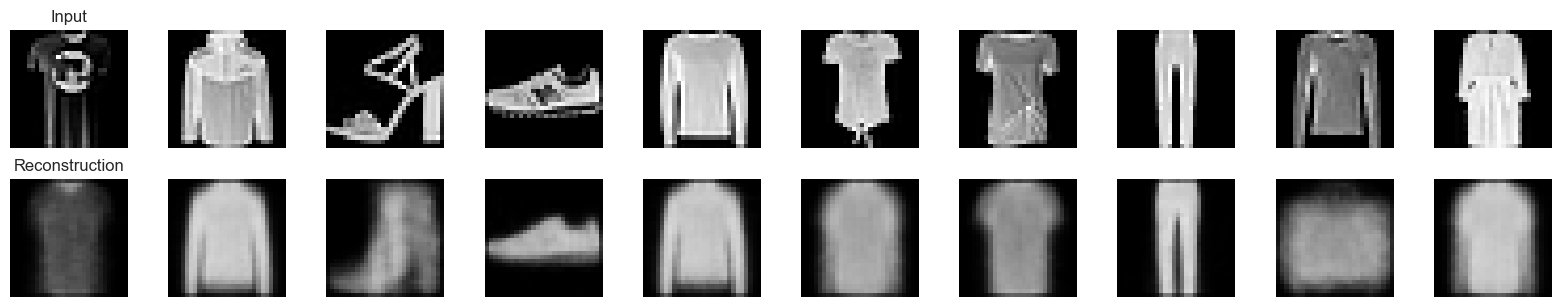

In [14]:
# Utility: show input vs reconstruction for N random test samples
def show_original_vs_recon(model: VAE, x, n=10, seed=SEED):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x), size=n, replace=False)
    x_sel = x[idx]
    mu, log_var, z = model.encoder.predict(x_sel, verbose=0)
    x_hat = model.decoder.predict(z, verbose=0)

    fig, axes = plt.subplots(2, n, figsize=(1.6*n, 3.2))
    for i in range(n):
        axes[0, i].imshow(x_sel[i].squeeze(), cmap="gray", vmin=0, vmax=1)
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Input")
        axes[1, i].imshow(x_hat[i].squeeze(), cmap="gray", vmin=0, vmax=1)
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Reconstruction")
    plt.tight_layout()
    plt.show()

show_original_vs_recon(vae2, x_test, n=10)

---

# Model3

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# -------------------------
# Losses (scalar outputs)
# -------------------------
def reconstruction_loss_mse(x: tf.Tensor, x_hat: tf.Tensor, reduction: str = "mean") -> tf.Tensor:
    """
    MSE reconstruction loss.
    reduction:
      - "sum": sum over H,W,C per sample, then mean over batch (scale depends on image size)
      - "mean": mean over H,W,C per sample, then mean over batch (scale invariant to image size)
    Returns a scalar.
    """
    per_pixel = tf.math.squared_difference(x, x_hat)
    if reduction == "sum":
        per_sample = tf.reduce_sum(per_pixel, axis=[1, 2, 3])
    elif reduction == "mean":
        per_sample = tf.reduce_mean(per_pixel, axis=[1, 2, 3])
    else:
        raise ValueError("reduction must be 'sum' or 'mean'")
    return tf.reduce_mean(per_sample)

def kl_loss_diag_gaussian(mu: tf.Tensor, log_var: tf.Tensor) -> tf.Tensor:
    """
    KL(q||p) where q = N(mu, diag(exp(log_var))) and p = N(0, I).
    Sum across latent dims per sample, then mean across batch. Returns a scalar.
    """
    kl_per_sample = 0.5 * tf.reduce_sum(
        tf.square(mu) + tf.exp(log_var) - log_var - 1.0, axis=1
    )
    return tf.reduce_mean(kl_per_sample)

# -------------------------
# Sampling layer
# -------------------------
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps

# -------------------------
# Encoder / Decoder builders
# -------------------------
def build_encoder(latent_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(inputs)  # 14x14
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)       # 7x7
    x = layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
    mu = layers.Dense(latent_dim, name="z_mu")(x)
    log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([mu, log_var])
    return keras.Model(inputs, [mu, log_var, z], name=f"encoder_ld{latent_dim}")

def build_decoder_upsampling(latent_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128, activation="relu", kernel_initializer="he_normal")(inputs)
    x = layers.Reshape((7, 7, 128))(x)
    # Upsampling-based decoder for cleaner reconstructions
    x = layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)  # 7x7
    x = layers.UpSampling2D(size=2)(x)  # 14x14
    x = layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.UpSampling2D(size=2)(x)  # 28x28
    x = layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    outputs = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name=f"decoder_ld{latent_dim}_ups")

# -------------------------
# VAE model with KL warm-up
# -------------------------
class VAE(keras.Model):
    def __init__(
        self,
        encoder: keras.Model,
        decoder: keras.Model,
        kl_final_weight: float = 1.0,
        recon_reduction: str = "mean",
        **kwargs
    ):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = tf.Variable(kl_final_weight, trainable=False, dtype=tf.float32, name="kl_weight")
        self.recon_reduction = recon_reduction
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        # Keras will log these as loss, recon_loss, kl_loss, and their val_* counterparts
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def compute_losses(self, x, training: bool):
        mu, log_var, z = self.encoder(x, training=training)
        x_hat = self.decoder(z, training=training)
        # reconstruction loss
        per_pixel = tf.math.squared_difference(x, x_hat)
        if self.recon_reduction == "mean":
            recon_per_sample = tf.reduce_mean(per_pixel, axis=[1, 2, 3])
        else:
            recon_per_sample = tf.reduce_sum(per_pixel, axis=[1, 2, 3])
        recon = tf.reduce_mean(recon_per_sample)
        # KL
        kl_per_sample = 0.5 * tf.reduce_sum(tf.square(mu) + tf.exp(log_var) - log_var - 1.0, axis=1)
        kl = tf.reduce_mean(kl_per_sample)
        # total
        loss = recon + self.kl_weight * kl
        return loss, recon, kl

    def train_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        with tf.GradientTape() as tape:
            loss, recon, kl = self.compute_losses(x, training=True)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        # IMPORTANT: update trackers also in validation so val_recon_loss exists
        x = data[0] if isinstance(data, tuple) else data
        loss, recon, kl = self.compute_losses(x, training=False)
        self.total_loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}


In [21]:
class KLDWarmUpCallback(keras.callbacks.Callback):
    """Linearly increase model.kl_weight from 0 to kl_final_weight over warmup_epochs."""
    def __init__(self, warmup_epochs: int = 40, kl_final_weight: float = 1.0):
        super().__init__()
        self.warmup_epochs = max(0, int(warmup_epochs))
        self.kl_final_weight = float(kl_final_weight)

    def on_train_begin(self, logs=None):
        if self.warmup_epochs > 0:
            self.model.kl_weight.assign(0.0)
        else:
            self.model.kl_weight.assign(self.kl_final_weight)

    def on_epoch_end(self, epoch, logs=None):
        if self.warmup_epochs > 0 and (epoch + 1) <= self.warmup_epochs:
            frac = (epoch + 1) / self.warmup_epochs
            self.model.kl_weight.assign(self.kl_final_weight * frac)

In [22]:
# -------------------------
# Utilities
# -------------------------
def show_original_vs_recon(model: VAE, x, n=10, seed: int = 42, sample: bool = False):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x), size=n, replace=False)
    x_sel = x[idx]
    mu, log_var, z_sample = model.encoder.predict(x_sel, verbose=0)
    z = z_sample if sample else mu  # deterministic by default
    x_hat = model.decoder.predict(z, verbose=0)

    fig, axes = plt.subplots(2, n, figsize=(1.6*n, 3.2))
    for i in range(n):
        axes[0, i].imshow(x_sel[i].squeeze(), cmap="gray", vmin=0, vmax=1); axes[0, i].axis("off")
        if i == 0: axes[0, i].set_title("Input")
        axes[1, i].imshow(x_hat[i].squeeze(), cmap="gray", vmin=0, vmax=1); axes[1, i].axis("off")
        if i == 0: axes[1, i].set_title("Reconstruction")
    plt.tight_layout(); plt.show()

In [30]:
def train_vae_dh2(
    x_train,
    x_test,
    epochs: int = 60,
    batch_size: int = 128,
    lr: float = 1e-4,
    kl_warmup_epochs: int = 40,
    recon_reduction: str = "mean",
):
    enc = build_encoder(latent_dim=2)
    dec = build_decoder_upsampling(latent_dim=2)
    vae = VAE(enc, dec, kl_final_weight=1.0, recon_reduction=recon_reduction)
    vae.compile(optimizer=keras.optimizers.Adam(lr, clipnorm=1.0))
    callbacks = [
    KLDWarmUpCallback(warmup_epochs=kl_warmup_epochs, kl_final_weight=1.0),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_recon_loss", mode="min",
        factor=0.5, patience=5, verbose=1, min_lr=5e-5
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_recon_loss", mode="min",
        patience=10, restore_best_weights=True, verbose=1
    ),
]
    history = vae.fit(
        x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None),
        callbacks=callbacks,
        verbose=2,
    )
    return vae, history

Epoch 1/60
469/469 - 120s - 257ms/step - kl_loss: 12.3565 - loss: 0.0519 - recon_loss: 0.0519 - val_kl_loss: 17.0715 - val_loss: 0.0400 - val_recon_loss: 0.0400 - learning_rate: 1.0000e-04
Epoch 2/60
469/469 - 135s - 288ms/step - kl_loss: 0.3125 - loss: 0.0943 - recon_loss: 0.0865 - val_kl_loss: 0.1970 - val_loss: 0.0863 - val_recon_loss: 0.0814 - learning_rate: 1.0000e-04
Epoch 3/60
469/469 - 125s - 267ms/step - kl_loss: 0.0549 - loss: 0.0887 - recon_loss: 0.0860 - val_kl_loss: 0.0452 - val_loss: 0.0877 - val_recon_loss: 0.0854 - learning_rate: 1.0000e-04
Epoch 4/60
469/469 - 123s - 263ms/step - kl_loss: 0.0221 - loss: 0.0885 - recon_loss: 0.0868 - val_kl_loss: 0.0190 - val_loss: 0.0879 - val_recon_loss: 0.0864 - learning_rate: 1.0000e-04
Epoch 5/60
469/469 - 125s - 266ms/step - kl_loss: 0.0128 - loss: 0.0883 - recon_loss: 0.0870 - val_kl_loss: 0.0121 - val_loss: 0.0878 - val_recon_loss: 0.0866 - learning_rate: 1.0000e-04
Epoch 6/60

Epoch 6: ReduceLROnPlateau reducing learning rate t

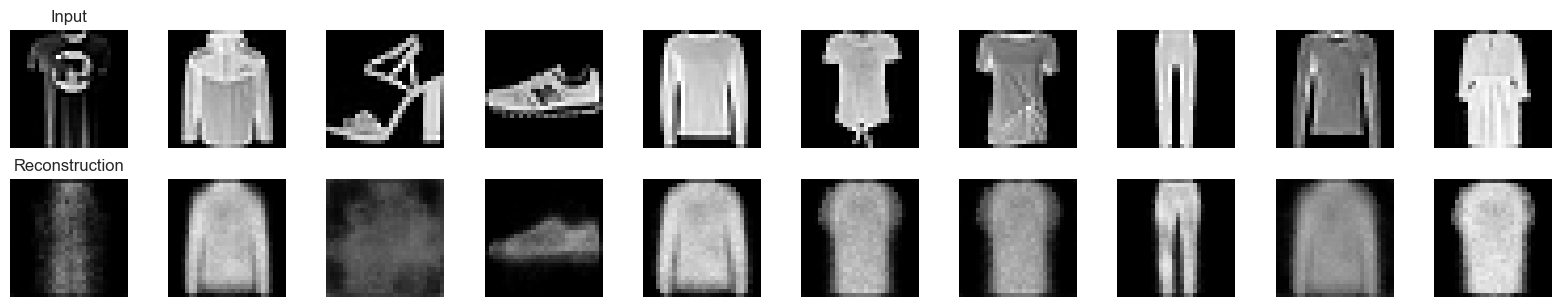

In [31]:
import numpy as np
from tensorflow import keras


# Data
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
x_train = (x_train.astype("float32") / 255.0)[..., None]
x_test  = (x_test.astype("float32")  / 255.0)[..., None]

# Train (D_h = 2)
model, history = train_vae_dh2(
    x_train=x_train,
    x_test=x_test,
    epochs=60,
    batch_size=128,
    lr=1e-4,
    kl_warmup_epochs=40,
    recon_reduction="mean",  # try "sum" if you want original scaling
)

# Visualize
show_original_vs_recon(model, x_test, n=10, seed=42, sample=False)